# Install and import libraries

In [ ]:
!pip install ydata_profiling==4.5.1
!pip install matplotlib==3.7.3
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install category_encoders
!pip install imblearn
!pip install tabulate
!pip install seaborn

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression

# Regression Task

Read data

In [36]:
df = pd.read_json('couriers_data.json')

## Preprocessing data

In [37]:
#encode column 'courier_transport'
custom_mapping = {
    'automobile': 4,
    'bicycle': 3,
    'scooter': 2,
    'foot': 1,
}
df['courier_transport'] = df['courier_transport'].map(custom_mapping)

Make new feature instead two datetimes features. Retrieve day, month and hour of starting job

In [38]:
#make new column - working time (in minutes) courier 
df['work_start'] = pd.to_datetime(df['work_start'])
df['work_finish'] = pd.to_datetime(df['work_finish'])
# Calculate the time difference in minutes
df['minutes_engaged'] = (df['work_finish'] - df['work_start']).dt.total_seconds() / 60.0
df['day'] = df['work_start'].dt.day
df['month'] = df['work_start'].dt.month
df['hour'] = df['work_start'].dt.hour

#sort by time like time series and delete this feature (not meaningfull)
df.sort_values(by=['work_start'])
df.drop(['work_start', 'work_finish'], axis = 1, inplace=True)

### Split Data

In [39]:
Y = df[['total_deliveries']] #targer value
X = df.drop(['total_deliveries'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle = False) # shuffle = False - time series

### Scaling
It scales and transforms features (variables) in a dataset so that they fall within a specific range, typically between 0 and 1. MinMax scaling ensures that all features are on the same scale, making it easier for machine learning algorithms to work with the data. When features have different scales, some algorithms may give more weight to features with larger values, leading to biased or suboptimal results.

In [40]:
columns_to_scale = [name for name in X_train.columns if name != 'courier_transport']

# Create scaler instance
scaler = MinMaxScaler()
scaler.fit(X_train[columns_to_scale])

# Transform the selected columns to standardize them
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

scaler.fit(y_train)
y_train = pd.DataFrame(scaler.transform(y_train))
y_test = pd.DataFrame(scaler.transform(y_test))

### Feature Selecting
Lasso (Least Absolute Shrinkage and Selection Operator) is a regularization technique used in linear regression and other machine learning models to select important features and prevent overfitting. 

In [41]:
# Create a Lasso model
lasso = Lasso(alpha=0.001)
# Fit the Lasso model on the training data
lasso.fit(X_train, y_train)
# Get the feature importances or coefficients
feature_importances = lasso.coef_
importance_dict = dict(zip(X_train.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_importance)

df.drop(['courier_id', 'late_pickups(%)', 'day', 'month', 'hour'], axis = 1, inplace=True) #has zeroes coeficient

[('max_unique_pickups', 0.6043191197950485), ('minutes_engaged', 0.1444173057273459), ('late_deliveries(%)', -0.015967814862944206), ('courier_transport', 0.007331151874506309), ('courier_id', 0.0), ('late_pickups(%)', -0.0), ('day', -0.0), ('month', 0.0), ('hour', 0.0)]


### DATA VISUALIZATION

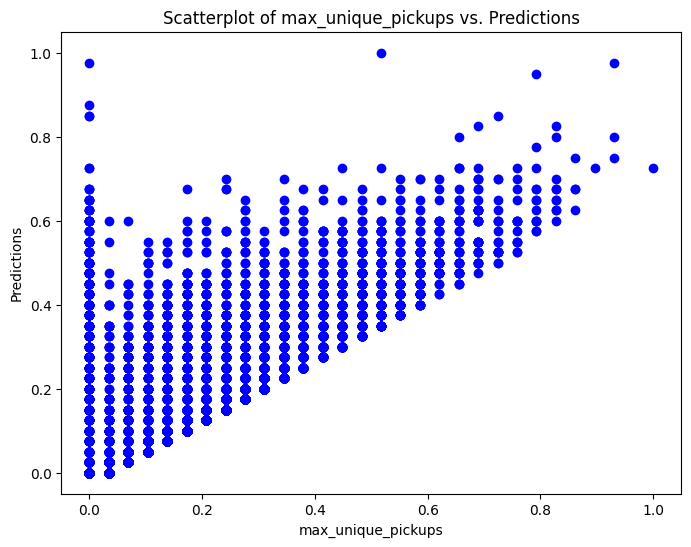

In [42]:
#plot depency of max_unique_pickups on target value (max_unique_pickups more correlate)
plt.figure(figsize=(8, 6))
plt.scatter(X_train['max_unique_pickups'], y_train, c='blue')
plt.xlabel('max_unique_pickups')
plt.ylabel('Predictions')
plt.title(f'Scatterplot of max_unique_pickups vs. Predictions')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


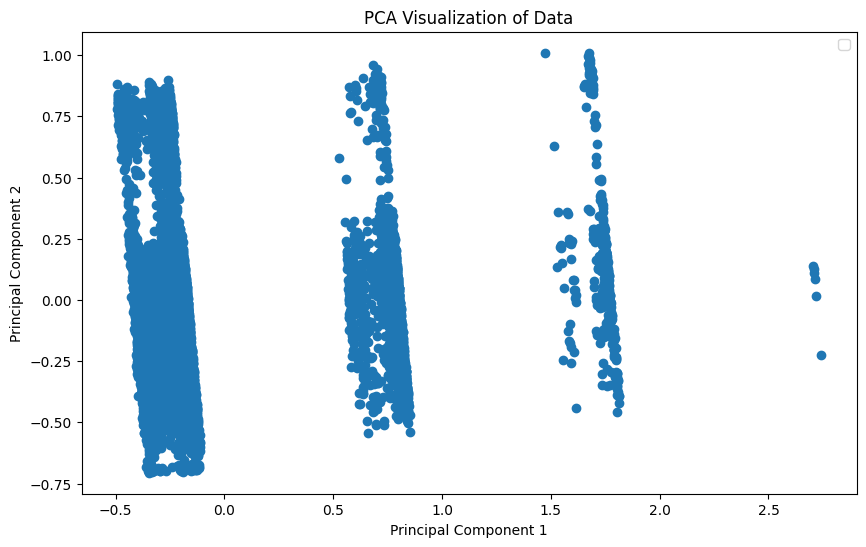

In [43]:
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

On first picture we see, that we have something similar to a linear relationship. On the second one we also see several groups of linearly dependent points. 

### Model train and evaluate

In [48]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)
print("\n LinearRegression")
print('Mean Absolute Error train:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Root Mean Squared Error train:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('coefficient of determination  𝑅2 train:', metrics.r2_score(y_train, y_pred_train)) 
print('Mean Absolute Error test:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Root Mean Squared Error test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('coefficient of determination  𝑅2 test:', metrics.r2_score(y_test, y_pred_test))

regressor = Lasso()
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)
print("\n Lasso")
print('Mean Absolute Error train:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Root Mean Squared Error train:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('coefficient of determination  𝑅2 train:', metrics.r2_score(y_train, y_pred_train)) 
print('Mean Absolute Error test:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Root Mean Squared Error test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('coefficient of determination  𝑅2 test:', metrics.r2_score(y_test, y_pred_test))

regressor = Ridge()
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)
print("\n Ridge")
print('Mean Absolute Error train:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Root Mean Squared Error train:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('coefficient of determination  𝑅2 train:', metrics.r2_score(y_train, y_pred_train)) 
print('Mean Absolute Error test:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Root Mean Squared Error test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('coefficient of determination  𝑅2 test:', metrics.r2_score(y_test, y_pred_test))

print("\n Polynomial regression")
degrees = [2, 4, 6, 8]
for i in range(len(degrees)):
    poly = PolynomialFeatures(degree=degrees[i])  # You can adjust the degree as needed
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_poly_train, y_train)
    y_pred_train = regressor.predict(X_poly_train)
    y_pred_test = regressor.predict(X_poly_test)
    print("\n degree of polynomial ", degrees[i])
    print('Mean Absolute Error train:', metrics.mean_absolute_error(y_train, y_pred_train))
    print('Root Mean Squared Error train:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    print('coefficient of determination  𝑅2 train:', metrics.r2_score(y_train, y_pred_train)) 
    print('Mean Absolute Error test:', metrics.mean_absolute_error(y_test, y_pred_test))
    print('Root Mean Squared Error test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    print('coefficient of determination  𝑅2 test:', metrics.r2_score(y_test, y_pred_test))


 LinearRegression
Mean Absolute Error train: 0.05916996851051483
Root Mean Squared Error train: 0.08959445074418257
coefficient of determination  𝑅2 train: 0.6584460162897587
Mean Absolute Error test: 0.05700907562448495
Root Mean Squared Error test: 0.08619814673499283
coefficient of determination  𝑅2 test: 0.6039164782347346

 Lasso
Mean Absolute Error train: 0.12439681912697993
Root Mean Squared Error train: 0.1533032753893507
coefficient of determination  𝑅2 train: 0.0
Mean Absolute Error test: 0.11488271142361069
Root Mean Squared Error test: 0.139906129913129
coefficient of determination  𝑅2 test: -0.0434326072730562

 Ridge
Mean Absolute Error train: 0.059204129588392385
Root Mean Squared Error train: 0.08959539075058676
coefficient of determination  𝑅2 train: 0.6584388492249762
Mean Absolute Error test: 0.05703437245989278
Root Mean Squared Error test: 0.08621076045529957
coefficient of determination  𝑅2 test: 0.6038005487745406

 Polynomial regression

 degree of polynomial  

# Classification task

### Read Data

In [50]:
df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time']) #like time series
df.drop(['order_create_time'], axis = 1, inplace=True)

## Preprocessing data

In [51]:
df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other' # impute missing values by frequance

#encode the data
label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])

### Split the data

In [52]:
train, test = train_test_split(df, test_size=0.1, shuffle = False) #like time-series

### Impute the missing cells

In [53]:
columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean') #calculate mean for each vendor
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

### Split X and Y

In [54]:
y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

### Feature selection

In [55]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
feature_importances = lasso.coef_
importance_dict = dict(zip(X_train.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_importance)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

[('total_order_items', 0.010248993400864664), ('payment_type', -0.0024601396164804943), ('tot_unique_items', -0.0013718401294962744), ('predicted_order_preparation_time', -0.0003723963665687729), ('cost(USD)', 0.00019058899383892782), ('estimated_delivery_time', -1.2432622589692792e-05), ('vendor_id', -9.628939839720953e-06), ('vendor_client_distance', -3.158827594933669e-06)]


### Scaling with RobustScaler, becuase we have outliers

In [56]:
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

scaler = RobustScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

### DATA VISUALIZATION

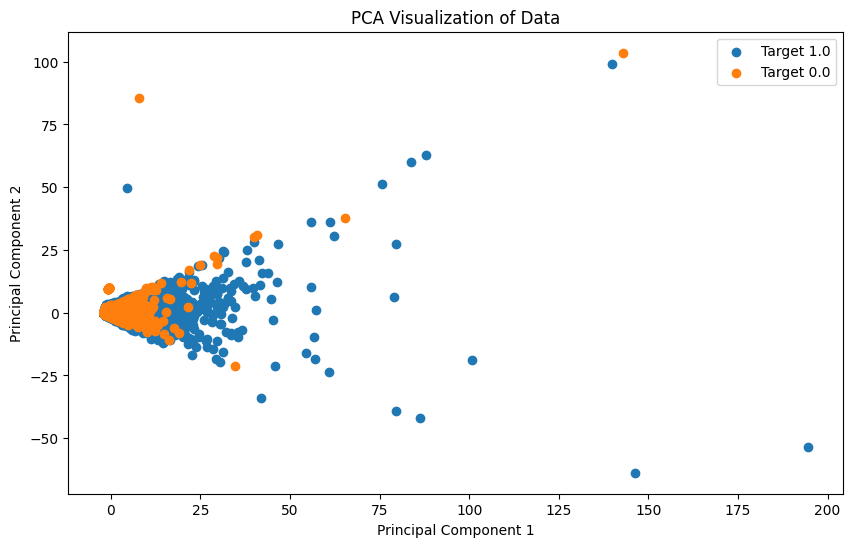

In [57]:
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

We can see that data the two classes are poorly separable.
For classification problem difficult to analyze plot dependece target value on feature, because we will se two lines on graph, parallel axes X, and that's all (on y axese will be 2 distinnct values: 0 and 1)

### Train models and evaluate without remove outliers and imbalance

In [58]:
# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


LogisticRegression with L1
Train accuracy = 0.8722561232380617
Train precision = 0.8722503225905264
Train recall = 0.9999780516926534
Testing accuracy = 0.8639104220499569
Testing precision = 0.8639104220499569
Testing recall = 1.0
Confusion Matrix:
 [[    0  3950]
 [    0 25075]]

LogisticRegression with L2
Train accuracy = 0.8722561232380617
Train precision = 0.8722503225905264
Train recall = 0.9999780516926534
Testing accuracy = 0.8639104220499569
Testing precision = 0.8639104220499569
Testing recall = 1.0
Confusion Matrix:
 [[    0  3950]
 [    0 25075]]


### Train models and evaluate with remove outliers and imbalance

In [80]:
df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time']) #like time series
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other' # impute missing values by frequance

#encode the data
label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])

train, test = train_test_split(df, test_size=0.1, shuffle = False) #like time-series

train = train.loc[(train['cost(USD)']) > 0]
train = train.loc[(train['total_order_items']) > 0 & (train['tot_unique_items'] > 0)]

q = train["cost(USD)"].quantile(0.95)
train = train.loc[train["cost(USD)"] <= q]
q = train["total_order_items"].quantile(0.95)
train = train.loc[train["total_order_items"] <= q] #remove outliers and from unique

q = train["estimated_delivery_time"].quantile(0.95)
train = train.loc[train["estimated_delivery_time"] <= q]
q = train["vendor_client_distance"].quantile(0.95)
train = train.loc[train["vendor_client_distance"] <= q]
q = train["predicted_order_preparation_time"].quantile(0.95)
train = train.loc[train["predicted_order_preparation_time"] <= q]

columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean') #calculate mean for each vendor
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


LogisticRegression with L1
Train accuracy = 0.9999372210617631
Train precision = 0.9999372210617631
Train recall = 1.0
Testing accuracy = 0.8639104220499569
Testing precision = 0.8639104220499569
Testing recall = 1.0
Confusion Matrix:
 [[    0  3950]
 [    0 25075]]

LogisticRegression with L2
Train accuracy = 0.9999372210617631
Train precision = 0.9999372210617631
Train recall = 1.0
Testing accuracy = 0.8639104220499569
Testing precision = 0.8639104220499569
Testing recall = 1.0
Confusion Matrix:
 [[    0  3950]
 [    0 25075]]


### Train models and evaluate with remove outliers and balance OverSampling

In [81]:
df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time']) #like time series
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other' # impute missing values by frequance

#encode the data
label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])

train, test = train_test_split(df, test_size=0.1, shuffle = False) #like time-series

train = train.loc[(train['cost(USD)']) > 0]
train = train.loc[(train['total_order_items']) > 0 & (train['tot_unique_items'] > 0)]

q = train["cost(USD)"].quantile(0.95)
train = train.loc[train["cost(USD)"] <= q]
#checked if tot_unique_items > total_order_items -> it's none
q = train["total_order_items"].quantile(0.95)
train = train.loc[train["total_order_items"] <= q] #remove outliers and from unique

q = train["estimated_delivery_time"].quantile(0.95)
train = train.loc[train["estimated_delivery_time"] <= q]
q = train["vendor_client_distance"].quantile(0.95)
train = train.loc[train["vendor_client_distance"] <= q]
q = train["predicted_order_preparation_time"].quantile(0.95)
train = train.loc[train["predicted_order_preparation_time"] <= q]

columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean') #calculate mean for each vendor
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

#balance
over_sampl = RandomOverSampler(random_state=0)
X_train, y_train = over_sampl.fit_resample(X_train, y_train)

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


LogisticRegression with L1
Train accuracy = 0.8552711935025427
Train precision = 0.8980330468590138
Train recall = 0.8015547324022442
Testing accuracy = 0.7605857019810508
Testing precision = 0.8737936154417223
Testing recall = 0.8449052841475573
Confusion Matrix:
 [[  890  3060]
 [ 3889 21186]]

LogisticRegression with L2
Train accuracy = 0.8552883161060917
Train precision = 0.8980369588848391
Train recall = 0.8015889776093421
Testing accuracy = 0.7605857019810508
Testing precision = 0.8737936154417223
Testing recall = 0.8449052841475573
Confusion Matrix:
 [[  890  3060]
 [ 3889 21186]]


### Train models and evaluate with remove outliers and balance UperSampling

In [82]:
df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time']) #like time series
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other' # impute missing values by frequance

#encode the data
label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])

train, test = train_test_split(df, test_size=0.1, shuffle = False) #like time-series

train = train.loc[(train['cost(USD)']) > 0]
train = train.loc[(train['total_order_items']) > 0 & (train['tot_unique_items'] > 0)]

q = train["cost(USD)"].quantile(0.95)
train = train.loc[train["cost(USD)"] <= q]
#checked if tot_unique_items > total_order_items -> it's none
q = train["total_order_items"].quantile(0.95)
train = train.loc[train["total_order_items"] <= q] #remove outliers and from unique

q = train["estimated_delivery_time"].quantile(0.95)
train = train.loc[train["estimated_delivery_time"] <= q]
q = train["vendor_client_distance"].quantile(0.95)
train = train.loc[train["vendor_client_distance"] <= q]
q = train["predicted_order_preparation_time"].quantile(0.95)
train = train.loc[train["predicted_order_preparation_time"] <= q]

columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean') #calculate mean for each vendor
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

#balance
under_sampl = RandomUnderSampler(random_state=0)
X_train, y_train = under_sampl.fit_resample(X_train, y_train)

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


LogisticRegression with L1
Train accuracy = 0.9090909090909091
Train precision = 1.0
Train recall = 0.8181818181818182
Testing accuracy = 0.678380706287683
Testing precision = 0.8827448691761501
Testing recall = 0.7238683948155533
Confusion Matrix:
 [[ 1539  2411]
 [ 6924 18151]]

LogisticRegression with L2
Train accuracy = 0.8636363636363636
Train precision = 0.8333333333333334
Train recall = 0.9090909090909091
Testing accuracy = 0.7272006890611542
Testing precision = 0.8788922750761892
Testing recall = 0.79357926221336
Confusion Matrix:
 [[ 1208  2742]
 [ 5176 19899]]


### Train models and evaluate with remove outliers and balance UperSampling+OverSampling

In [79]:
df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = False)

# remove outliers from train
train = train.loc[(train['cost(USD)']) > 0]
train = train.loc[(train['total_order_items']) > 0 & (train['tot_unique_items'] > 0)]

q = train["cost(USD)"].quantile(0.95)
train = train.loc[train["cost(USD)"] <= q]
#check if tot_unique_items > total_order_items -> it's none
q = train["total_order_items"].quantile(0.95)
train = train.loc[train["total_order_items"] <= q] #remove outliers and from unique

q = train["estimated_delivery_time"].quantile(0.95)
train = train.loc[train["estimated_delivery_time"] <= q]
q = train["vendor_client_distance"].quantile(0.95)
train = train.loc[train["vendor_client_distance"] <= q]

#impute
columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean')
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)
    

train.drop(['tot_unique_items'], axis = 1, inplace=True)
test.drop(['tot_unique_items'], axis = 1, inplace=True)
train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create StandardScaler instance
scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

#balance
smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


LogisticRegression with L1
Train accuracy = 0.6131343099598535
Train precision = 0.61274048076799
Train recall = 0.5488704858442316
Testing accuracy = 0.5811197243755384
Testing precision = 0.8888086207934501
Testing recall = 0.5887936191425723
Confusion Matrix:
 [[ 2103  1847]
 [10311 14764]]

LogisticRegression with L2
Train accuracy = 0.6131343099598535
Train precision = 0.612741935483871
Train recall = 0.5488647068002012
Testing accuracy = 0.5810852713178295
Testing precision = 0.8888019265502709
Testing recall = 0.588753738783649
Confusion Matrix:
 [[ 2103  1847]
 [10312 14763]]
